### En lo posible, realizar videos donde una clase de objeto difiera en número con otros objetos (sino, utilizar videos bajados de internet). Por ejemplo, al aire libre, un perro que se mueva entre personas en un parque. Una persona en bicicleta entre muchos autos en una calle de la ciudad. Luego, utilizar los distintos algoritmos presentados en teoría para detectar solo la clase minoritaria con su respectiva etiqueta. Indicando en cada caso la herramienta utilizada y comparando los niveles de confianza de detección logrados.

In [1]:
%%capture
# Instalar la biblioteca pytube
!pip install pytube
!apt update && apt install -y handbrake

from pytube import YouTube


In [2]:

# URL del video de YouTube
url = 'https://www.youtube.com/watch?v=pqQSwQLDIK8'

# Crear un objeto YouTube
yt = YouTube(url)

# Seleccionar el stream con resolución de 720p
video = yt.streams.filter(progressive=True, file_extension='mp4', res="720p").first()

# Nombre del archivo de salida
output_filename = 'quilombo.mp4'

# Descargar el video con el nombre especificado
video.download(filename=output_filename)

print("Descarga completada.")

Descarga completada.


In [3]:
#Esto convierte el video a un formato más liviano de trabajo
!ffmpeg -y -i quilombo.mp4 -vf "scale=600:-1" -an -t 30 quilombo_scaled.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [4]:
%pip install ultralytics
# Librería mediapy para mostrar videos
%pip install -q mediapy
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.1/107.7 GB disk)


100% 6.23M/6.23M [00:00<00:00, 24.6MB/s]
Ultralytics YOLOv8.2.0 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

100% 165k/165k [00:00<00:00, 2.24MB/s]
image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 387.7ms
Speed: 21.3ms preprocess, 387.7ms inference, 5172.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


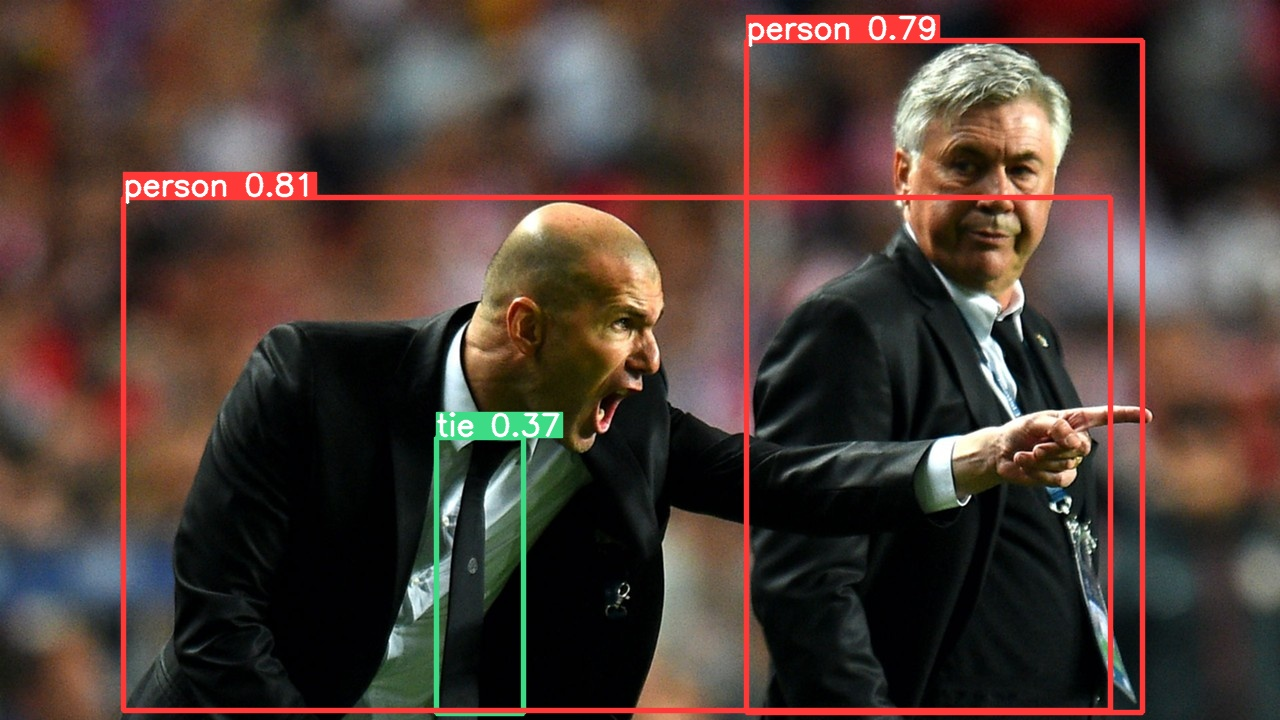

In [5]:
# Run inference on an image with YOLOv8n
!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/zidane.jpg'
from IPython.display import Image
Image('runs/detect/predict/zidane.jpg')

In [6]:
import mediapy as media

In [7]:
url = '/content/quilombo_scaled.mp4'
video = media.read_video(url)
media.show_video(video)

In [8]:
import cv2  # Importar OpenCV para el procesamiento de imágenes y videos
import numpy as np
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n')  # This will automatically download the model weights


In [9]:

# Función para detectar objetos en una imagen:
def detect_objects(new_image, prev_image, **kwargs):
    # Convertir la imagen a float32
    results = model(new_image)

    # Clases de interés para graficar
    classes = kwargs.get('classes', ['car', 'truck'])

    # Iteramos sobre los boung boxes obtenidos
    for box in results[0].boxes:
        # Extrayendo los datos del tensor
        x1, y1, x2, y2, confidence, cls = box.data[0]

        # Obteniendo el nombre de la clase
        class_name = model.names[int(cls)]

        # Parámetros opcionales del bounding box
        color = kwargs.get('color', (0, 255, 0))
        thickness = kwargs.get('thickness', 2)

        if class_name in classes:
            # Dibujar el rectángulo
            cv2.rectangle(new_image, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

            # Agregar el texto de la confianza
            confidence_text = f"{class_name}: {confidence:.2f}"
            cv2.putText(new_image, confidence_text, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return new_image

# Función para procesar un video:
def video_processor(filename_in, filename_out, process_func, max_time=10, **kwargs):
    # Abrir el video de entrada para lectura
    with media.VideoReader(filename_in) as r:
        # Crear un archivo de video de salida
        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:
            count = 0  # Inicializar contador de fotogramas
            prev_image = None  # Inicializar la imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                new_image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Comprobar si es la primera imagen
                if prev_image is None:
                    prev_image = new_image.copy()

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(new_image, prev_image, **kwargs)

                # Añadir la imagen procesada al video de salida
                w.add_image(processed_image)

                # Actualizar la imagen previa
                prev_image = new_image.copy()

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break



In [11]:
# Nombres de los archivos de video de entrada y salida
filename_in = '/content/quilombo_scaled.mp4'
filename_out = 'quilombo_scaled_object_recog.mp4'
parameters = dict(classes=['car'])

# Llamar a la función para procesar el video
video_processor(filename_in, filename_out, detect_objects, 20, **parameters)

# Mostrar el video resultante
media.show_video(media.read_video(filename_out), fps=30)


0: 384x640 9 persons, 3 bicycles, 1 car, 3 motorcycles, 228.9ms
Speed: 3.3ms preprocess, 228.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 8 bicycles, 1 car, 144.9ms
Speed: 2.3ms preprocess, 144.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 5 bicycles, 1 car, 152.0ms
Speed: 4.0ms preprocess, 152.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 bicycles, 1 car, 1 motorcycle, 158.2ms
Speed: 2.9ms preprocess, 158.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 5 bicycles, 1 car, 147.2ms
Speed: 3.2ms preprocess, 147.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 6 bicycles, 1 car, 144.6ms
Speed: 3.3ms preprocess, 144.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 5 bicycles, 1 car, 141.2ms
Speed: 2.9ms preprocess, 141